In [2]:
# load some standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math #math fun
import matplotlib.pyplot as plt #plotting
from mpl_toolkits.mplot3d import Axes3D #3d plots
from sklearn.neighbors import NearestNeighbors 

In [3]:
import zipfile
z = zipfile.ZipFile(r"..\Data\historical-hourly-weather-data.zip")

In [4]:
cityTable = pd.read_csv(z.open("city_attributes.csv"))
temperatureDF = pd.read_csv(z.open("temperature.csv"), index_col=0)
temperatureDF.index = pd.to_datetime(temperatureDF.index)

In [5]:
def takensEmbedding (data,delay,dimension):
    if delay*dimension > len(data):
          raise NameError('Delay times dimension exceed length of data!')    
    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    
    return embeddedData;
        

In [6]:
t = pd.date_range(pd.to_datetime('22/6/2015', dayfirst=True), pd.to_datetime('31/8/2015', dayfirst=True), freq='H')

In [7]:
len(temperatureDF),len(t),min(t),max(t)

(45253,
 1681,
 Timestamp('2015-06-22 00:00:00', freq='H'),
 Timestamp('2015-08-31 00:00:00', freq='H'))

In [8]:
weatherDataMontreal = temperatureDF.loc[t,'Montreal']

C:\Users\cernu\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


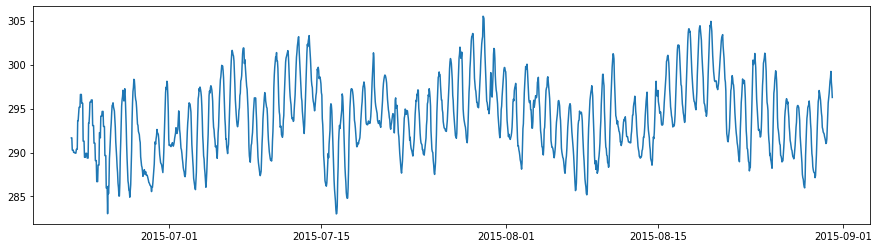

In [9]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(weatherDataMontreal)

In [10]:
windowSize = 24
lowPassFilteredSignal = weatherDataMontreal.rolling(windowSize, center=True).mean()

In [11]:
filteredWeatherData = (weatherDataMontreal - lowPassFilteredSignal).dropna()
#filtered[0:15]
#filtered.dropna(inplace=True)

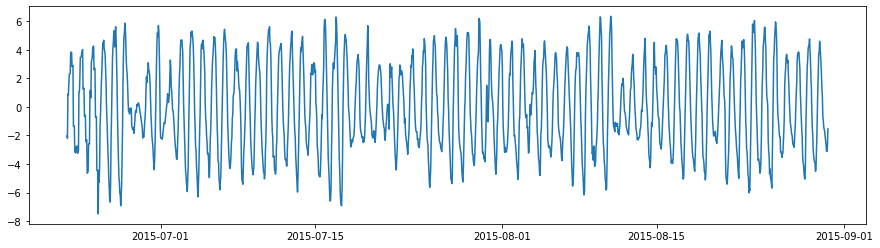

In [12]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(filteredWeatherData)

In [13]:
embeddedWeather = takensEmbedding(filteredWeatherData, 5, 2)

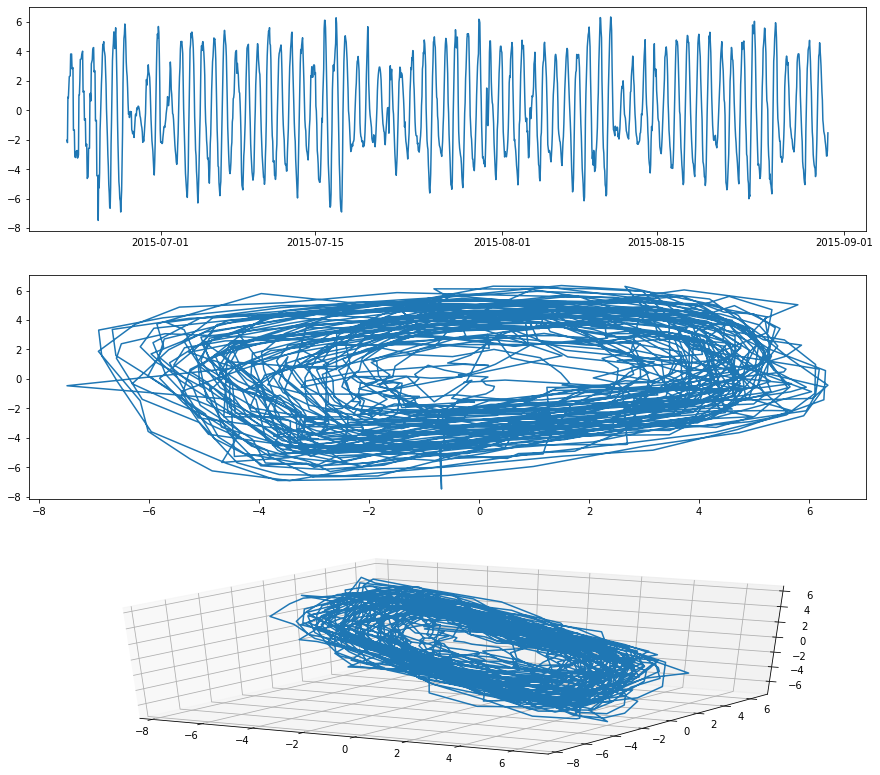

In [14]:
#plot the time-series and the embedded one 
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,14));
ax[0].plot(filteredWeatherData);
ax[1].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[2].axis('off')
#embed into three dimensions
embeddedWeather3 = takensEmbedding(filteredWeatherData, 6,3);
#plot the 3D embedding
ax = fig.add_subplot(3, 1, 3, projection='3d')
ax.plot(embeddedWeather3[0,:],embeddedWeather3[1,:],embeddedWeather3[2,:]);

In [19]:
def mutualInformation(data, delay, nBins):
    "This function calculates the mutual information given the delay"
    I = 0;
    xmax = max(data);
    xmin = min(data);
    delayData = data[delay:len(data)];
    shortData = data[0:len(data)-delay];
    sizeBin = abs(xmax - xmin) / nBins;
    #the use of dictionaries makes the process a bit faster
    probInBin = {};
    conditionBin = {};
    conditionDelayBin = {};
    for h in range(0,nBins):
        if h not in probInBin:
            conditionBin.update({h : (shortData >= (xmin + h*sizeBin)) & (shortData < (xmin + (h+1)*sizeBin))})
            probInBin.update({h : len(shortData[conditionBin[h]]) / len(shortData)});
        for k in range(0,nBins):
            if k not in probInBin:
                conditionBin.update({k : (shortData >= (xmin + k*sizeBin)) & (shortData < (xmin + (k+1)*sizeBin))});
                probInBin.update({k : len(shortData[conditionBin[k]]) / len(shortData)});
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (delayData >= (xmin + k*sizeBin)) & (delayData < (xmin + (k+1)*sizeBin))});
            Phk = len(shortData[conditionBin[h] & conditionDelayBin[k]]) / len(shortData);
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log( Phk / (probInBin[h] * probInBin[k]));
    return I;

Wall time: 10 s


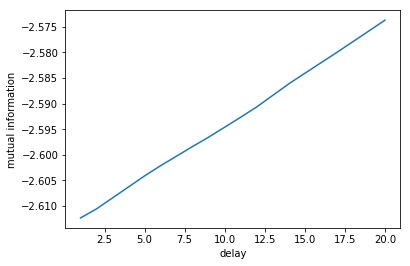

In [21]:
%%time 
datDelayInformation = []
for i in range(1,21):
    datDelayInformation = np.append(datDelayInformation,[mutualInformation(filteredWeatherData,i,16)])
plt.plot(range(1,21),datDelayInformation);
plt.xlabel('delay');
plt.ylabel('mutual information');

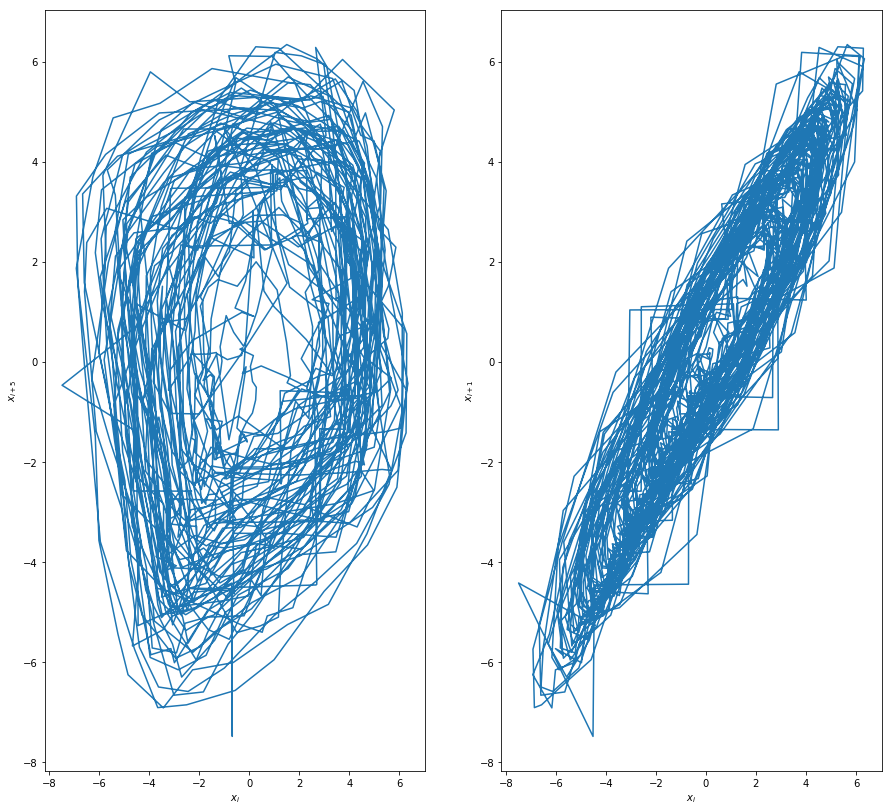

In [23]:
#embedd into two dimensions
embeddedWeather = takensEmbedding(filteredWeatherData,5,2);
#plot the time-series and the embedded one 
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,14));
ax[0].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[0].set_xlabel('$x_i$');
ax[0].set_ylabel('$x_{i+5}$');
#now with delay=1
embeddedWeather = takensEmbedding(filteredWeatherData,1,2);
ax[1].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[1].set_xlabel('$x_i$');
ax[1].set_ylabel('$x_{i+1}$');



In [92]:
tempDf = temperatureDF.copy()

In [24]:
def false_nearest_neighours(data,delay,embeddingDimension):
    "Calculates the number of false nearest neighbours of embedding dimension"    
    embeddedData = takensEmbedding(data,delay,embeddingDimension);
    #the first nearest neighbour is the data point itself, so we choose the second one
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData.transpose())
    distances, indices = nbrs.kneighbors(embeddedData.transpose())
    #two data points are nearest neighbours if their distance is smaller than the standard deviation
    epsilon = np.std(distances.flatten())
    nFalseNN = 0
    for i in range(0, len(data)-delay*(embeddingDimension+1)):
        if (0 < distances[i,1]) and (distances[i,1] < epsilon) and ( (abs(data[i+embeddingDimension*delay] - data[indices[i,1]+embeddingDimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN

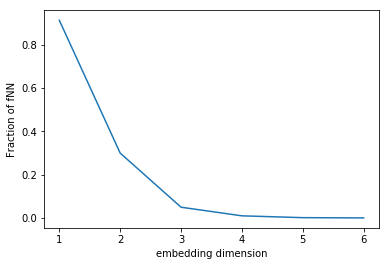

In [26]:
nFNN = []
for i in range(1,7):
    nFNN.append(false_nearest_neighours(filteredWeatherData,1,i) / len(filteredWeatherData))
plt.plot(range(1,7),nFNN);
plt.xlabel('embedding dimension');
plt.ylabel('Fraction of fNN');

In [65]:
_embeddedData = takensEmbedding(filteredWeatherData,1,5)[0:100];    
_nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(_embeddedData.transpose())
_distances, _indices = _nbrs.kneighbors(_embeddedData.transpose())
_distances[0:100]

array([[0.        , 1.19611868],
       [0.        , 1.15701745],
       [0.        , 0.92471337],
       [0.        , 0.84160109],
       [0.        , 0.82160069],
       [0.        , 0.55300123],
       [0.        , 0.54268225],
       [0.        , 0.67241284],
       [0.        , 0.38928697],
       [0.        , 0.56872697],
       [0.        , 0.85505021],
       [0.        , 0.99209522],
       [0.        , 1.1631845 ],
       [0.        , 1.67790947],
       [0.        , 0.93527543],
       [0.        , 0.82893244],
       [0.        , 1.01312248],
       [0.        , 0.20849273],
       [0.        , 0.42708365],
       [0.        , 0.43229544],
       [0.        , 0.34696928],
       [0.        , 0.39748035],
       [0.        , 1.6095474 ],
       [0.        , 0.98877488],
       [0.        , 1.46355108],
       [0.        , 1.46763614],
       [0.        , 0.51345903],
       [0.        , 0.59652323],
       [0.        , 0.5975883 ],
       [0.        , 0.32368928],
       [0.

In [66]:
[ x for [_,x] in _distances[0:100]]

[1.1961186825636652,
 1.1570174532619988,
 0.924713365874955,
 0.8416010875854391,
 0.8216006872174546,
 0.5530012259505771,
 0.5426822482535232,
 0.6724128428653727,
 0.38928696837920523,
 0.5687269699244578,
 0.8550502097017815,
 0.992095216399437,
 1.163184503522989,
 1.6779094719858654,
 0.9352754273474005,
 0.8289324376038884,
 1.0131224766917089,
 0.20849272652496934,
 0.4270836524389538,
 0.43229543572649237,
 0.3469692764776467,
 0.3974803541616503,
 1.6095473979938872,
 0.9887748802880497,
 1.4635510830062926,
 1.4676361402873157,
 0.5134590298626094,
 0.596523232585226,
 0.5975882968812912,
 0.32368928002018066,
 0.32368928002018066,
 0.8341356356613852,
 0.8369587108574873,
 1.3354967741183157,
 1.3302934076162407,
 0.928003692970363,
 1.0238870109104385,
 1.1090832010605822,
 0.7829904069848711,
 0.8318188007977452,
 1.100240913485785,
 1.0900206730644235,
 1.0998700522990594,
 1.3364984334072176,
 0.42436442058488166,
 1.0621702078042041,
 1.6909302117186376,
 0.9887748802

In [50]:
for x in _embeddedData[0:100]: display(x)

array([-2.03704167, -2.20079167,  0.88945833, ..., -1.73416667,
       -2.09458333, -2.33833333])

array([-2.20079167,  0.88945833,  0.84716667, ..., -2.09458333,
       -2.33833333, -2.67041667])

array([ 0.88945833,  0.84716667,  1.609875  , ..., -2.33833333,
       -2.67041667, -3.1175    ])

array([ 0.84716667,  1.609875  ,  2.28758333, ..., -2.67041667,
       -3.1175    , -3.11083333])

array([ 1.609875  ,  2.28758333,  2.31075   , ..., -3.1175    ,
       -3.11083333, -2.73708333])

In [67]:
_embeddedData[:,0:40]

array([[-2.03704167, -2.20079167,  0.88945833,  0.84716667,  1.609875  ,
         2.28758333,  2.31075   ,  2.33391667,  3.81808333,  3.81895833,
         3.81983333,  2.81470833,  2.856     ,  2.89729167, -1.36141667,
        -1.35      , -1.33858333, -3.1685    , -3.193     , -3.2175    ,
        -2.793     , -2.766875  , -2.74075   , -3.252625  , -3.14704167,
        -3.04145833,  1.035125  ,  1.04495833,  1.98779167,  3.451625  ,
         3.467125  ,  3.482625  ,  3.744125  ,  3.878125  ,  4.012125  ,
         1.233125  ,  1.26620833,  1.29929167, -0.669625  , -0.62433333],
       [-2.20079167,  0.88945833,  0.84716667,  1.609875  ,  2.28758333,
         2.31075   ,  2.33391667,  3.81808333,  3.81895833,  3.81983333,
         2.81470833,  2.856     ,  2.89729167, -1.36141667, -1.35      ,
        -1.33858333, -3.1685    , -3.193     , -3.2175    , -2.793     ,
        -2.766875  , -2.74075   , -3.252625  , -3.14704167, -3.04145833,
         1.035125  ,  1.04495833,  1.98779167,  3.

In [39]:
embeddedData = takensEmbedding(data,delay,embeddingDimension);
nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData.transpose())
distances, indices = nbrs.kneighbors(embeddedData.transpose())

NameError: name 'embeddedData' is not defined

In [61]:
filteredWeatherData[0:100].to_csv("filteredWeatherData_0-99.csv")